In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-09-12 14:06:32.768449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757685993.012458      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757685993.079875      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import preprocess_input

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [6]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [7]:
train = train_datagen.flow_from_directory(
    '/kaggle/input/split-monkey-pox-dataset/Monkey split/train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation = validation_datagen.flow_from_directory(
    '/kaggle/input/split-monkey-pox-dataset/Monkey split/val',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

test = validation_datagen.flow_from_directory(
    '/kaggle/input/split-monkey-pox-dataset/Monkey split/test',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

Found 4200 images belonging to 6 classes.
Found 900 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


In [8]:
InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False, 
    weights = 'imagenet', 
    input_shape=(224,224,3),
    )

I0000 00:00:1757686432.349817      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
InceptionV3.trainable = False

In [10]:
model = tf.keras.models.Sequential([
  InceptionV3,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=6, activation='softmax'), 
])

In [11]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    52,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,760,486 (285.19 MB)

 Trainable params: 52,957,702 (202.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [12]:
history = model.fit(
    x = train, 
    validation_data = validation,
    epochs = 10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1757686465.299442     116 service.cc:148] XLA service 0x7a3fd4002990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757686465.300539     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757686467.308207     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/132 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.1328 - loss: 8.1179  

I0000 00:00:1757686474.354228     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 95s 569ms/step - accuracy: 0.4748 - loss: 7.0619 - val_accuracy: 0.8311 - val_loss: 0.4205
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - accuracy: 0.8251 - loss: 0.5023 - val_accuracy: 0.9333 - val_loss: 0.1892
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 355ms/step - accuracy: 0.8649 - loss: 0.3818 - val_accuracy: 0.9456 - val_loss: 0.1372
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 50s 375ms/step - accuracy: 0.8948 - loss: 0.3032 - val_accuracy: 0.9689 - val_loss: 0.1087
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 48s 362ms/step - accuracy: 0.9063 - loss: 0.2609 - val_accuracy: 0.9644 - val_loss: 0.1061
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 357ms/step - accuracy: 0.9092 - loss: 0.2584 - val_accuracy: 0.9389 - val_loss: 0.1453
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 350ms/step - accuracy: 0.9382 - loss: 0.1810 - val_accuracy: 0.9511 - val_loss: 0.1339
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 354ms/step - accuracy: 0.9305 - loss: 0.2125 - val

In [13]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9824 - loss: 0.0516
Accuracy: 0.9733333587646484
Loss: 0.06888415664434433


In [14]:
test.class_indices

{'Chickenpox': 0,
 'Cowpox': 1,
 'HFMD': 2,
 'Healthy': 3,
 'Measles': 4,
 'Monkeypox': 5}

In [16]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['Chickenpox', 'Cowpox', 'HFMD','Healthy','Measles','Monkeypox']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
              precision    recall  f1-score   support

  Chickenpox       0.96      0.99      0.98       150
      Cowpox       1.00      0.98      0.99       150
        HFMD       0.97      0.99      0.98       150
     Healthy       1.00      0.95      0.97       150
     Measles       0.97      0.99      0.98       150
   Monkeypox       0.95      0.94      0.94       150

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



<Axes: >

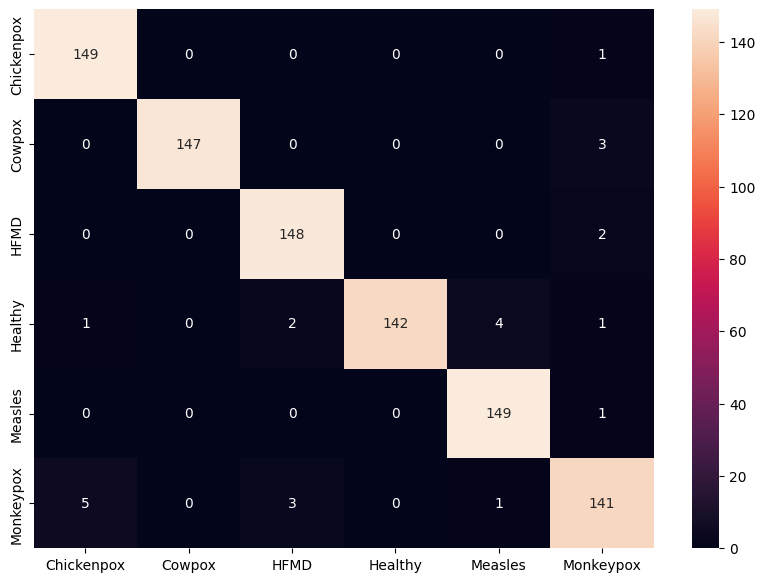

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Chickenpox', 'Cowpox', 'HFMD','Healthy','Measles','Monkeypox']],
                  columns = [i for i in ['Chickenpox', 'Cowpox', 'HFMD','Healthy','Measles','Monkeypox']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

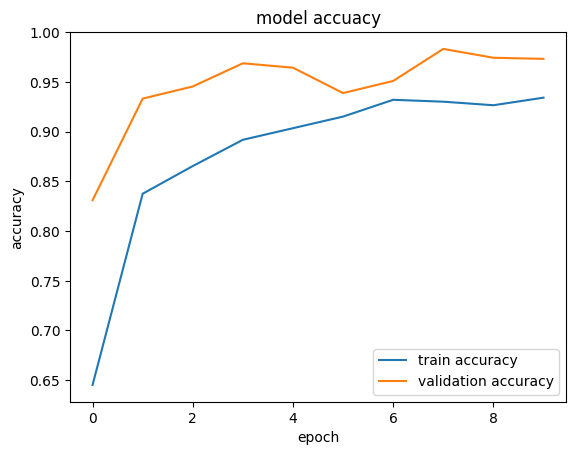

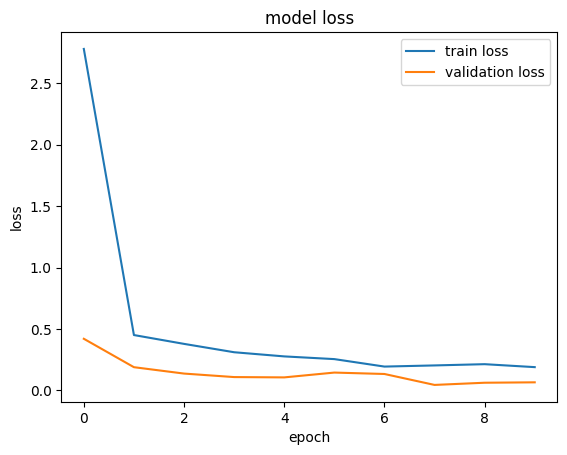

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()